# Machine learning modeling

baseline 모델로 randomforest를 이용한다.

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from importlib.util import find_spec
if find_spec("costa_rican") is None:
    import sys
    sys.path.append('..')

In [9]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set a few plotting defaults
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
plt.rcParams['patch.edgecolor'] = 'k'

In [10]:
import os
os.chdir(r"/home/skang/Documents/Costa_Rican_Household_Poverty_Level_Prediction/notebooks")

In [11]:
pd.options.display.max_columns = 150

# Read in data
train = pd.read_csv('../input/costa-rican-household-poverty-prediction/train.csv')
test = pd.read_csv('../input/costa-rican-household-poverty-prediction/test.csv')
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,no,10,no,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,8,12,no,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,8,no,11,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [12]:
from costa_rican.utils.feature_engineering import preprocessing_train_test_and_merge, features_v1, split_train_test

In [13]:
data = preprocessing_train_test_and_merge(train, test)
final = features_v1(data)
train_set, test_set, train_labels = split_train_test(final)

Before
There are 85 households where the family members do not all have the same target
After
There are 0 households where the family members do not all have the same target
There are 85 correlated columns to remove.


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

In [15]:
scorer_params = {
    'score_func': f1_score,
    'greater_is_better': True,
    'average': 'macro'
}

In [16]:
from costa_rican.utils.evaluation import make_custom_scorer

# cross validation을 위한 custom scorer
scorer = make_scorer(f1_score, greater_is_better=True, average = 'macro')

In [17]:
# submission 제출을 위한 base df
submission_base = test[['Id', 'idhogar']].copy()

다른 모델들을 비교할 것이기 때문에 특징들의 크기를 표준화 해준다. 대부분의 앙상블 모델에서는 이러한 작업이 불필요하지만, distance metric에 의존적인 모델을 사용하게 된다면 (KNearest Neighbors or Support vector machine) 이러한 feature scaling 작업이 필요하다.

`Pipeline` 함수를 이용하여 scaling과 결측값 처리를 같이 이어서 해준다.

In [18]:
from costa_rican.utils.training import fill_null_and_scaling

In [19]:
features = list(train_set.columns)
train_set, test_set = fill_null_and_scaling(train_set, test_set)

In [20]:
rf_params = {
    'n_estimators': 100,
    'random_state': 10,
    'n_jobs': -1
    }

In [21]:
from costa_rican.utils.evaluation import CVScore
rf_cv_score = CVScore(RandomForestClassifier, model_params=rf_params, scorer_params=scorer_params)

In [22]:
rf_cv_score.train(train_set, train_labels)

RandomForestClassifier
10 Fold Cross Validation F1 Score = 0.3426 with std = 0.0476


# Feature importance

tree base 모델의 경우 feature importances를 확인할 수 있다. 절대적인 크기가 아닌 상대적인 중요도를 확인해본다.

In [23]:
from costa_rican.utils.training import SklearnWrapper

In [24]:
rf_trainer = SklearnWrapper(RandomForestClassifier, params=rf_params)

rf_trainer.train(train_set, train_labels)
# Feature importances into a dataframe
feature_importances = rf_trainer.get_feature_importances()
feature_importances.head()

,feature,importance
0,hacdor,0.000701
1,hacapo,0.000476
2,v14a,0.000261
3,refrig,0.001715
4,paredblolad,0.006107


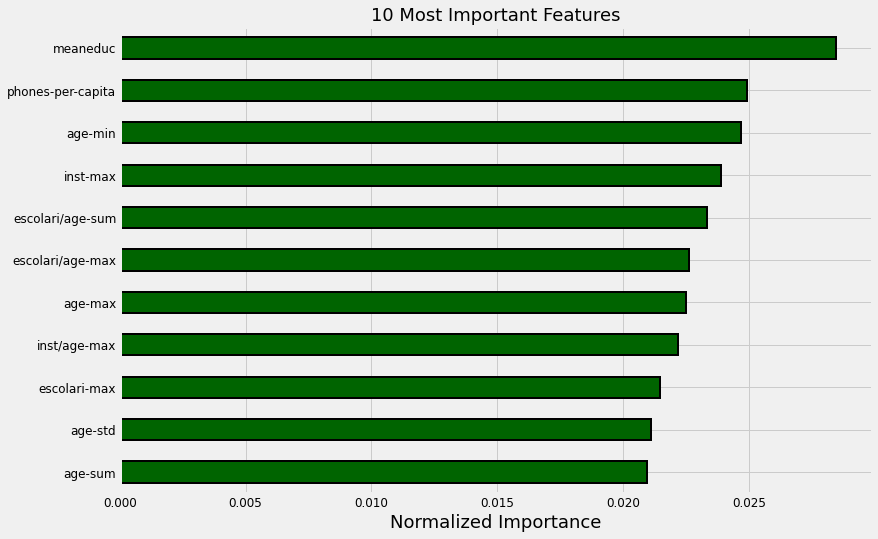

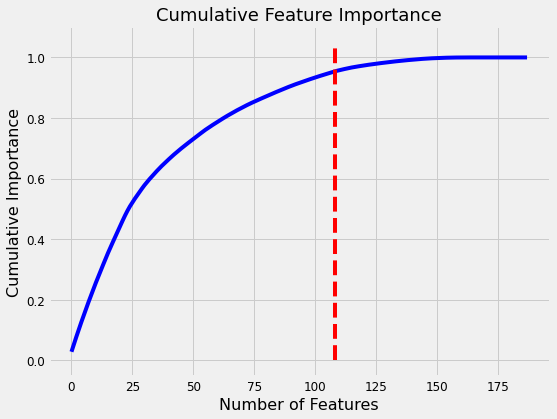

108 features required for 95% of cumulative importance.


In [25]:
from costa_rican.utils.visualization import PlotFeatureImportances

plot_feature_importances = PlotFeatureImportances()
df = plot_feature_importances(feature_importances, threshold=0.95)

In [26]:
df.head()

,feature,importance,importance_normalized,cumulative_importance
0,meaneduc,0.028454,0.028454,0.028454
1,phones-per-capita,0.024930,0.024930,0.053384
2,age-min,0.024681,0.024681,0.078065
3,inst-max,0.023913,0.023913,0.101978
4,escolari/age-sum,0.023342,0.023342,0.125319


### Education reigns supreme

In [27]:
from costa_rican.utils.visualization import KdePlotByTargetAndColumns

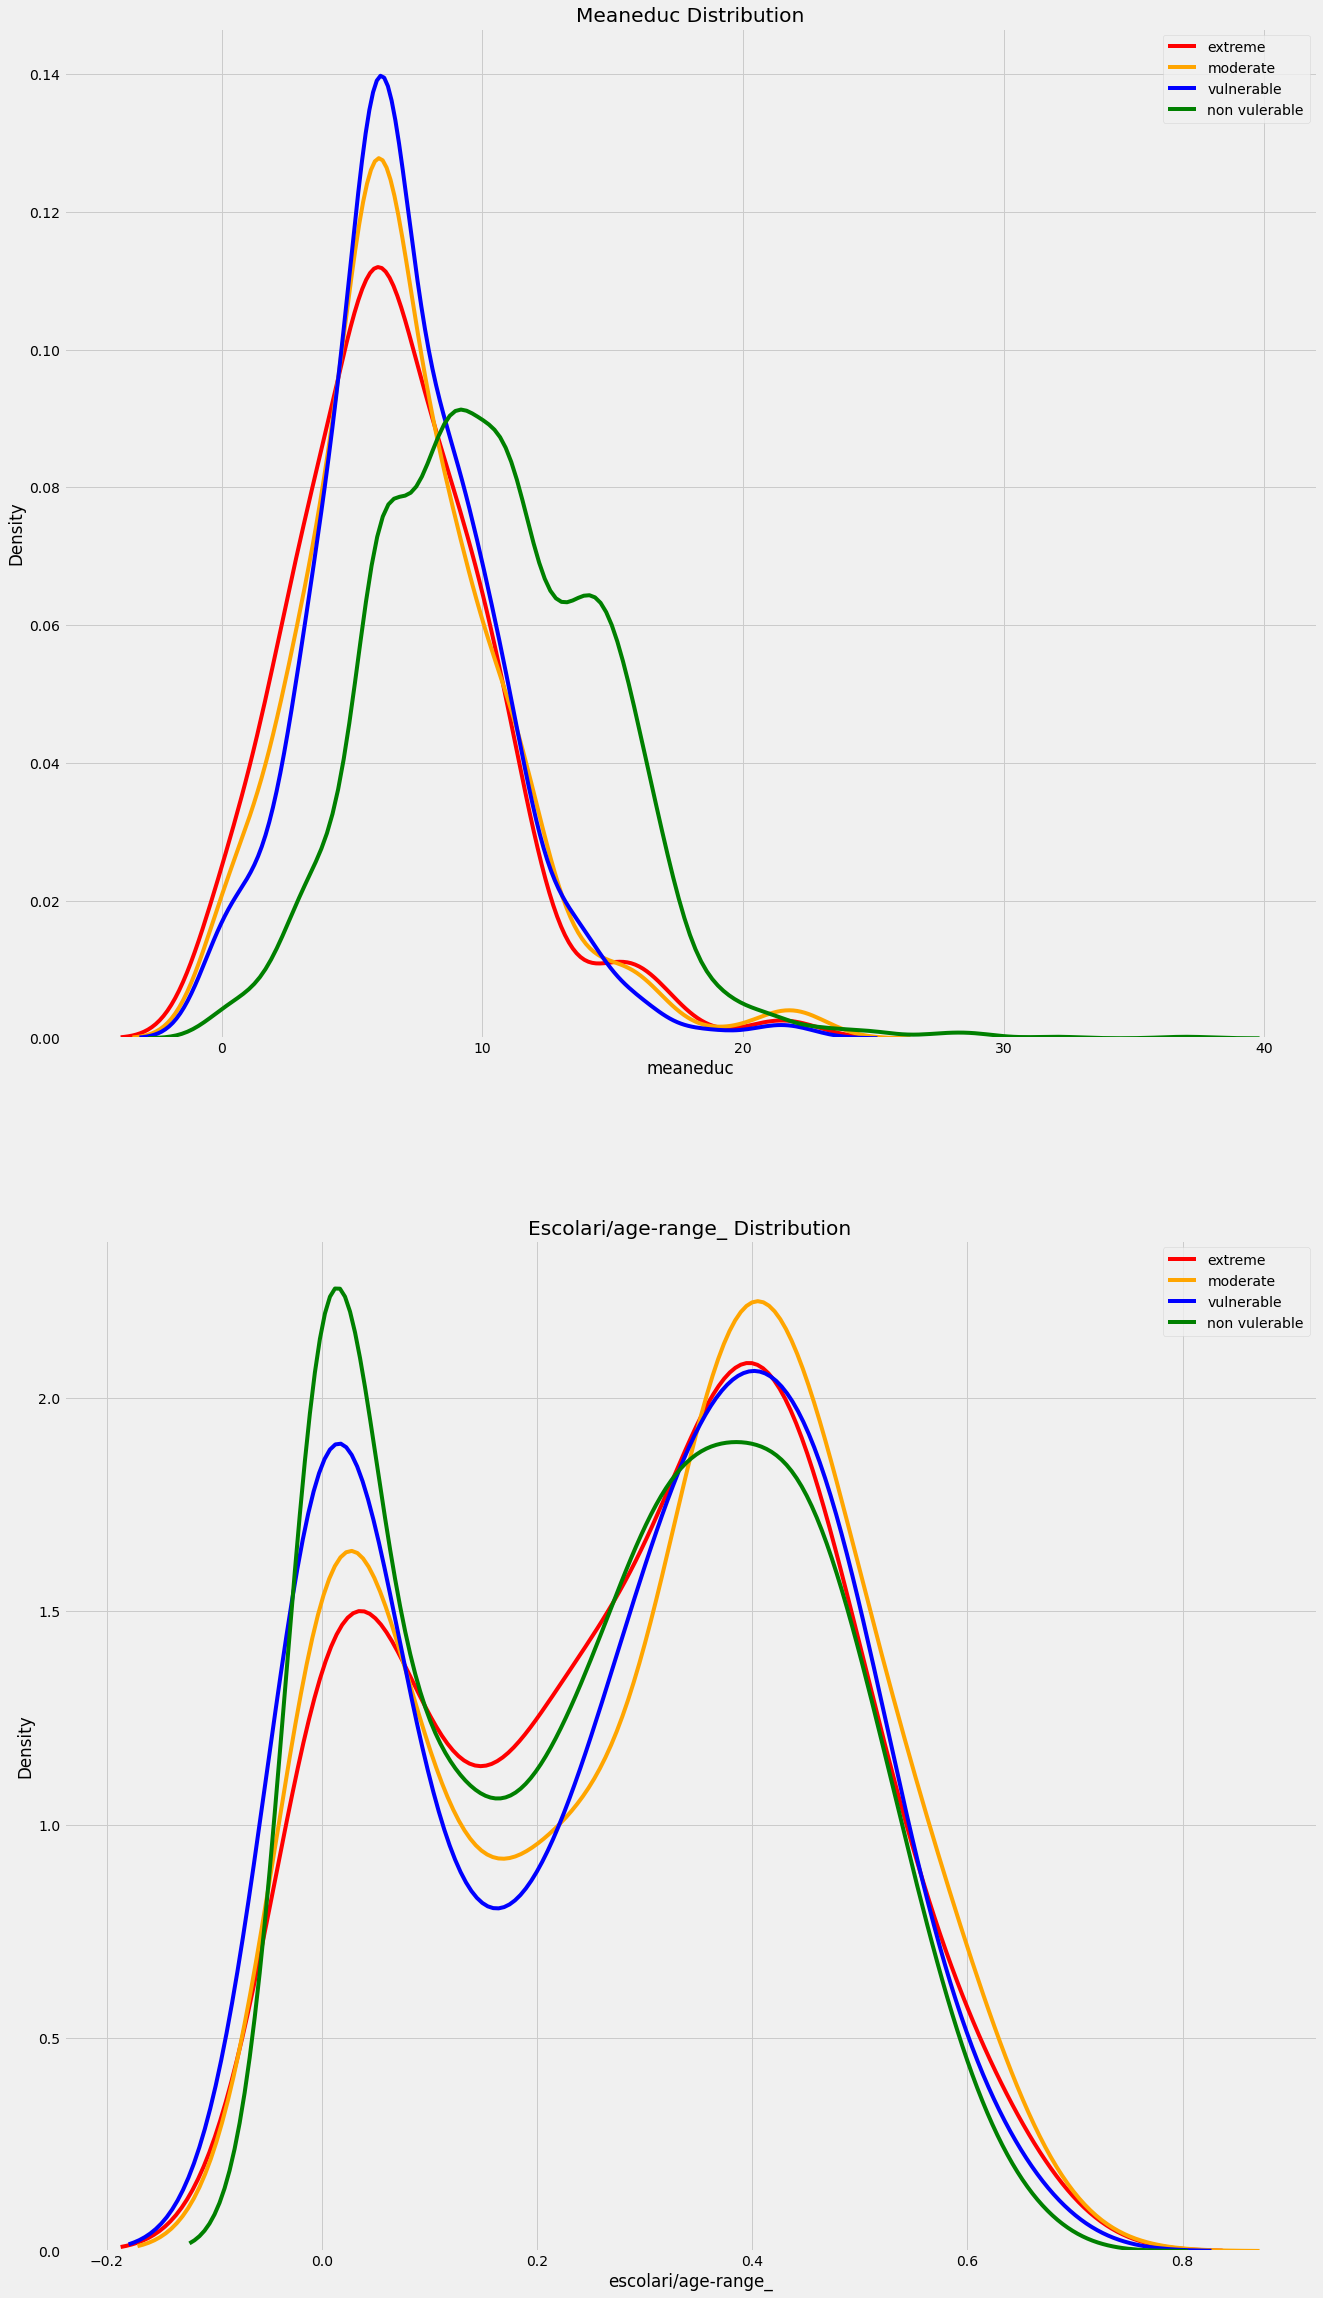

In [30]:
kde_target = KdePlotByTargetAndColumns(final)
kde_target(['meaneduc', 'escolari/age-range_'])

## Model Selection

In [31]:
# Model imports
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier